## **Linear decoding analysis of finetuned model**

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import pickle
import glob
import os
from thalamocortex.models import CTCNet, CTCNetThalReadout
from thalamocortex.utils import create_data_loaders, get_neuron_weights, plot_receptive_field, activation_hook
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from scipy.special import softmax
from scipy.stats import entropy
from sklearn.decomposition import KernelPCA, PCA
from sklearn import svm
from sklearn.manifold import TSNE

/Users/patmccarthy/miniconda3/envs/thalamocortex/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
save_path = "/Users/patmccarthy/Documents/phd/rotation1"

Load results

In [5]:
results_paths = {
    # "ff_MNIST_1": "/Users/patmccarthy/Documents/thalamocortex/results/25_02_24_feedforward_mnist_gridsearch2/0_CTCNet_TC_none",
    "ff_MNIST_finetune": "/Users/patmccarthy/Documents/thalamocortex/results/26_02_24_feedforward_finetune_binarymnist_run3/0_CTCNet_finetuning_ThalReadout_2",
}

In [6]:
results_paths

{'ff_MNIST_finetune': '/Users/patmccarthy/Documents/thalamocortex/results/26_02_24_feedforward_finetune_binarymnist_run3/0_CTCNet_finetuning_ThalReadout_2'}

Load model data and params

In [7]:
results = {}
for model_name, path in results_paths.items():
    
    # learning progress
    with open(Path(f"{path}", "learning.pkl"), "rb") as handle:
        learning = pickle.load(handle)

    # load hyperparams
    with open(Path(f"{path}", "hyperparams.pkl"), "rb") as handle:
        hp = pickle.load(handle)


    results[model_name] = {"val_losses": learning["val_losses"],
                           "train_losses": learning["train_losses"],
                           "train_time": learning["train_time"],
                           "state_dicts": learning["state_dicts"]}
                           

Instantiate model

In [8]:
# instantiate model
model = CTCNetThalReadout(input_size=hp["pretrained_params"]["input_size"],
                          ctx_output_size=hp["pretrained_params"]["output_size"],
                          thal_output_size=hp["thal_output_size"],
                          ctx_layer_size=hp["pretrained_params"]["ctx_layer_size"],
                          thal_layer_size=hp["pretrained_params"]["thal_layer_size"],
                          thalamocortical_type=hp["pretrained_params"]["thalamocortical_type"],
                          thal_reciprocal=hp["pretrained_params"]["thal_reciprocal"],
                          thal_to_readout=hp["pretrained_params"]["thal_to_readout"], 
                          thal_per_layer=hp["pretrained_params"]["thal_per_layer"],
                          )

In [9]:
# Register hooks for specific layers
activations = {}
hook_handles = []
for name, layer in model.named_modules():
    handle = layer.register_forward_hook(lambda module, input, output: activation_hook(module, input, output, activations))
    hook_handles.append(handle)

In [10]:
epoch = 49
model.load_state_dict(results["ff_MNIST_finetune"]["state_dicts"][epoch]) 

<All keys matched successfully>

Load dataset

In [11]:
trainset_loader, testset_loader, metadata = create_data_loaders(dataset="MNIST", norm="normalise", batch_size=32, save_path="/Users/patmccarthy/Documents/ThalamoCortex/data")

In [12]:
# load full training set
X_all = []
y_all = []
for X, y in iter(testset_loader):
    # X_all.append(X.detach().numpy()[:, 0, :, :])
    # y_all.append(y.detach().numpy()[:])
    X_all.append(X[:, :, :])
    y_all.append(y[:])

In [13]:
X_all_tensor = torch.cat(X_all, dim=0)  # Shape: [num_samples, 1, 28, 28]
y_all_tensor = torch.cat(y_all, dim=0)  # Shape: [num_samples]

# Convert to NumPy
X_all_arr = X_all_tensor.numpy()  # Shape: (num_samples, 1, 28, 28)
y_all_reshaped = y_all_tensor.numpy()  # Shape: (num_samples,)

# Reshape X to [samples, features]
X_all_reshaped = X_all_arr.reshape(X_all_arr.shape[0], -1)  # Shape: (num_samples, 28*28)


In [14]:
X_all_arr.shape

(10000, 1, 28, 28)

In [15]:
# X_all_arr = np.array(X_all)
# y_all_arr = np.array(y_all)
# X_all_reshaped = np.reshape(X_all_arr, newshape=(X_all_arr.shape[0] * X_all_arr[0].shape[1] * X_all_arr[0].shape[0] , X_all_arr[0].shape[2], X_all_arr[0].shape[3]))
# y_all_reshaped = np.reshape(y_all_arr, newshape=(y_all_arr.shape[0] * y_all_arr.shape[1]))

In [16]:
# inference (on full dataset)
with torch.no_grad():
    
    _, y_est_logits = model(torch.Tensor(X_all_reshaped))
    y_est_prob = softmax(y_est_logits.detach().numpy())
    y_est = np.argmax(y_est_prob, axis=1)

    # Remove hooks after use
    for handle in hook_handles:
        handle.remove()

In [17]:
X_all_reshaped.shape

(10000, 784)

In [18]:
y_est_prob.shape

(10000, 2)

linear decoding analysis

In [19]:
# activations.keys()

In [20]:
# select weights to decode from
weights_name = list(activations.keys())[0]
features = activations[weights_name].detach().numpy()

In [21]:
features.shape

(10000, 16)

In [22]:
# split into train and test set
train_test_split = 0.8
test_cutoff = int(len(features) * train_test_split)

X_train = features[:test_cutoff, :]
X_test = features[test_cutoff:, :]
y_train = y_all_reshaped[:test_cutoff]
y_test = y_all_reshaped[test_cutoff:]

In [23]:
test_cutoff

8000

In [24]:
# pca_transformer = KernelPCA(n_components=10, kernel="rbf")
# X_transformed = pca_transformer.fit_transform(features)

In [25]:
X_train.shape

(8000, 16)

In [26]:
y_train.shape

(8000,)

In [27]:
# train SVM classifier
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [28]:
# test SVM classifier
y_pred = clf.predict(X_test)

In [29]:
y_pred

array([1, 9, 8, ..., 9, 3, 7])

In [30]:
y_test

array([1, 9, 8, ..., 9, 3, 3])

In [31]:
correct = 0
for samp_idx in range(y_pred.shape[0]):
    if y_pred[samp_idx] == y_test[samp_idx]:
        correct += 1
accuracy = correct / y_pred.shape[0]

In [32]:
y_test.shape

(2000,)

In [33]:
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

Classification Accuracy: 90.70%


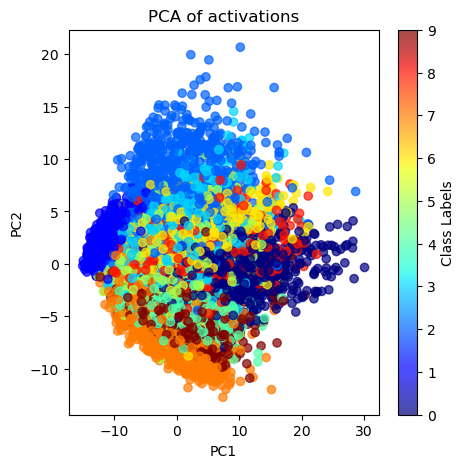

In [34]:
pca = PCA(n_components=2)
activations_2d = pca.fit_transform(features)

plt.figure(figsize=(5, 5))
scatter = plt.scatter(activations_2d[:, 0], activations_2d[:, 1], c=y_all_reshaped, cmap="jet", alpha=0.7)
plt.colorbar(scatter, label="Class Labels")
plt.title("PCA of activations")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [36]:
# Convert to NumPy if needed
activations = np.array(features)
y_true = np.array(y_all_reshaped)

# Step 1: Reduce dimensionality with PCA (keep 50 components)
pca = PCA(n_components=5)
activations_pca = pca.fit_transform(activations)

# Step 2: Apply t-SNE on reduced data
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
activations_2d = tsne.fit_transform(activations_pca)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(activations_2d[:, 0], activations_2d[:, 1], c=y_true, cmap="jet", alpha=0.7)
plt.colorbar(scatter, label="Class Labels")
plt.title("t-SNE Visualization (PCA Preprocessing)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


: 

In [ ]:

# # Convert to NumPy if needed
# activations = np.array(features)
# y_true = np.array(y_all_reshaped)

# # Reduce dimensions to 2D using t-SNE
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# activations_2d = tsne.fit_transform(activations)

# # Plot the t-SNE visualization
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(activations_2d[:, 0], activations_2d[:, 1], c=y_true, cmap="jet", alpha=0.7)
# plt.colorbar(scatter, label="Class Labels")
# plt.title("t-SNE of activations")
# plt.xlabel("component 1")
# plt.ylabel("component 2")
# plt.show()


: 